<a href="https://colab.research.google.com/github/habeshaethiopia/Handwritten-Digit-Generation-Web-App/blob/main/Handwritten%20Digit%20Generation%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using GPU: Tesla T4
Dataset loaded. Number of training samples: 60000
Starting Training Loop...
Epoch [1/50], Step [100/469], Loss D: 0.7984, Loss G: 2.0625, D_real_avg: 1.0481, D_fake_avg: -0.9213/-1.8718
Epoch [1/50], Step [200/469], Loss D: 1.2312, Loss G: 2.0543, D_real_avg: 1.6102, D_fake_avg: 0.4819/-1.8829
Epoch [1/50], Step [300/469], Loss D: 0.9473, Loss G: 1.1792, D_real_avg: 0.0034, D_fake_avg: -1.7167/-0.7489
Epoch [1/50], Step [400/469], Loss D: 0.6520, Loss G: 1.4952, D_real_avg: 1.9501, D_fake_avg: -0.6477/-1.1791
Epoch [2/50], Step [100/469], Loss D: 0.3635, Loss G: 1.8276, D_real_avg: 2.2700, D_fake_avg: -1.7122/-1.5545
Epoch [2/50], Step [200/469], Loss D: 0.4978, Loss G: 3.0529, D_real_avg: 2.8952, D_fake_avg: -0.9752/-2.9628
Epoch [2/50], Step [300/469], Loss D: 0.5316, Loss G: 2.3920, D_real_avg: 1.9366, D_fake_avg: -1.9434/-2.2463
Epoch [2/50], Step [400/469], Loss D: 0.5118, Loss G: 1.7337, D_real_avg: 1.8566, D_fake_avg: -1.5551/-1.4263
Epoch [3/50], Step [100/4

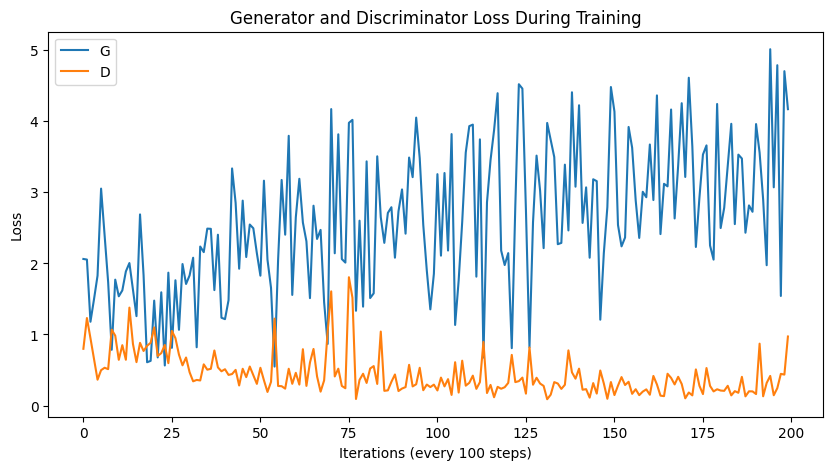

Trained Generator model saved to generator_cgan.pth


In [7]:
# Check if GPU is available and set device
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Install necessary libraries if not already present (gdown is useful for general drive downloads, but not needed here)
# !pip install torch torchvision matplotlib numpy

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Configuration ---
NUM_EPOCHS = 50          # Number of training epochs
BATCH_SIZE = 128         # Batch size for training
LATENT_DIM = 100         # Dimension of the latent noise vector
EMBED_DIM = 10           # Dimension for the label embedding
NUM_CLASSES = 10         # Number of classes (digits 0-9)
IMAGE_SIZE = 28          # MNIST image size
NUM_CHANNELS = 1         # Grayscale images
LR_G = 0.0002            # Learning rate for Generator
LR_D = 0.0002            # Learning rate for Discriminator
BETA1 = 0.5              # Beta1 for Adam optimizer
SAMPLE_INTERVAL = 5      # How often to save generated images (epochs) - less frequent to save space/time
MODEL_SAVE_PATH = 'generator_cgan.pth' # Path to save the trained generator model

# --- Data Transformations ---
# Normalize image pixel values to [-1, 1] for GAN training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- Load MNIST Dataset ---
# Download and load the training data
# MNIST dataset will be downloaded to './data' in your Colab environment
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Dataset loaded. Number of training samples: {len(train_dataset)}")

# --- Model Architectures ---

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, embed_dim, img_size, num_channels):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.img_size = img_size
        self.num_channels = num_channels

        # Embedding for the labels
        self.label_embedding = nn.Embedding(num_classes, embed_dim)

        # First fully connected layer to project noise and embedding to a spatial size
        # This size (256 * 7 * 7) is chosen so that subsequent transposed convolutions
        # can upsample it to 28x28.
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + embed_dim, 256 * 7 * 7),
            nn.BatchNorm1d(256 * 7 * 7),
            nn.ReLU(True)
        )

        # Deconvolutional layers to progressively upsample the image
        self.deconv_layers = nn.Sequential(
            # Input: 256 x 7 x 7
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False), # Output: 128 x 14 x 14
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, num_channels, 4, 2, 1, bias=False), # Output: num_channels x 28 x 28
            nn.Tanh() # Outputs pixel values in [-1, 1]
        )

    def forward(self, noise, labels):
        # Embed labels
        gen_input_label = self.label_embedding(labels)
        # Concatenate noise and label embedding
        gen_input = torch.cat((noise, gen_input_label), 1) # Concat along feature dimension

        # Project to spatial dimensions for deconvolution
        gen_input = self.fc(gen_input)
        gen_input = gen_input.view(-1, 256, 7, 7) # Reshape to 256 channels, 7x7 spatial

        # Pass through deconvolutional layers
        img = self.deconv_layers(gen_input)
        return img

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, num_classes, embed_dim, img_size, num_channels):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.img_size = img_size
        self.num_channels = num_channels

        self.label_embedding = nn.Embedding(num_classes, embed_dim)

        # Convolutional layers to downsample the image
        self.conv_layers = nn.Sequential(
            # Input: (num_channels + embed_dim for embedded label) x 28 x 28
            # We need to concatenate the label embedding across the spatial dimensions.
            # The input channels will be num_channels (1) + embed_dim (10) = 11
            nn.Conv2d(num_channels + embed_dim, 64, 4, 2, 1, bias=False), # Output: 64 x 14 x 14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False), # Output: 128 x 7 x 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Input: 128 x 7 x 7, Output: 256 x 3 x 3 based on kernel=4, stride=2, padding=1 calculation
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Classifier to output real/fake probability
        self.classifier = nn.Sequential(
            # Adjusted based on the actual output size of the last convolutional layer (256x3x3)
            nn.Linear(256 * 3 * 3, 1),
            # nn.Sigmoid() # BCELoss expects logits, BCEWithLogitsLoss expects raw scores, so no sigmoid here if using BCEWithLogitsLoss
        )

    def forward(self, img, labels):
        # Embed labels and tile them to match image dimensions
        # Embedding output is (batch_size, embed_dim).
        # View it to (batch_size, embed_dim, 1, 1) to align with image dimensions (channels, height, width).
        label_embedding = self.label_embedding(labels).view(labels.size(0), self.embed_dim, 1, 1)
        # Repeat the embedding spatially across the image height and width
        label_embedding = label_embedding.repeat(1, 1, self.img_size, self.img_size)

        # Concatenate image and label embedding along the channel dimension
        # Image shape: (batch_size, num_channels, img_size, img_size)
        # Label embedding shape: (batch_size, embed_dim, img_size, img_size)
        # Resulting shape: (batch_size, num_channels + embed_dim, img_size, img_size)
        d_input = torch.cat((img, label_embedding), 1)

        # Pass through convolutional layers
        features = self.conv_layers(d_input)
        # Flatten for the classifier
        features = features.view(features.size(0), -1) # Flatten all spatial and channel dimensions
        validity = self.classifier(features)
        return validity
# --- Initialize Models ---
generator = Generator(LATENT_DIM, NUM_CLASSES, EMBED_DIM, IMAGE_SIZE, NUM_CHANNELS).to(device)
discriminator = Discriminator(NUM_CLASSES, EMBED_DIM, IMAGE_SIZE, NUM_CHANNELS).to(device)

# --- Loss Function and Optimizers ---
# BCEWithLogitsLoss is more numerically stable than BCELoss followed by Sigmoid
criterion = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(generator.parameters(), lr=LR_G, betas=(BETA1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(BETA1, 0.999))

# --- Training Loop ---
print("Starting Training Loop...")

# For consistent generation during training updates
# We will generate 5 images for each digit (0-9)
fixed_noise = torch.randn(NUM_CLASSES * 5, LATENT_DIM, device=device)
fixed_labels = torch.LongTensor(np.repeat(np.arange(NUM_CLASSES), 5)).to(device) # Labels: [0,0,0,0,0,1,1,1,1,1,...]

# Ensure output directory exists for generated images
output_dir = 'generated_images'
os.makedirs(output_dir, exist_ok=True)

# Training statistics
g_losses = []
d_losses = []
img_list = [] # To store a batch of generated images for animation/review

for epoch in range(NUM_EPOCHS):
    for i, (real_images, labels) in enumerate(train_loader):
        real_images = real_images.to(device)
        labels = labels.to(device)
        batch_size = real_images.size(0)

        # Create real and fake labels for the discriminator (soft labels can also be used)
        real_target = torch.full((batch_size, 1), 1., dtype=torch.float, device=device) # (batch_size, 1) for BCEWithLogitsLoss
        fake_target = torch.full((batch_size, 1), 0., dtype=torch.float, device=device) # (batch_size, 1) for BCEWithLogitsLoss

        # --- Train Discriminator ---
        discriminator.zero_grad()

        # 1. Train with real images
        output_real = discriminator(real_images, labels)
        errD_real = criterion(output_real, real_target)
        errD_real.backward() # Computes gradients for D_real

        # 2. Train with fake images
        noise = torch.randn(batch_size, LATENT_DIM, device=device)
        # For training D, it's better to generate fake images with random labels for generalizability
        gen_labels = torch.randint(0, NUM_CLASSES, (batch_size,), device=device)

        fake_images = generator(noise, gen_labels)
        # Detach fake_images to prevent gradients from flowing to Generator during D's update
        output_fake = discriminator(fake_images.detach(), gen_labels)
        errD_fake = criterion(output_fake, fake_target)
        errD_fake.backward() # Computes gradients for D_fake

        # Combine losses and update D
        errD = errD_real + errD_fake
        optimizer_D.step()

        # --- Train Generator ---
        generator.zero_grad()

        # Generate new fake images with new noise and random labels for G's update
        noise = torch.randn(batch_size, LATENT_DIM, device=device)
        gen_labels = torch.randint(0, NUM_CLASSES, (batch_size,), device=device)
        fake_images = generator(noise, gen_labels)

        # Generator wants Discriminator to classify fake images as real
        output_gen = discriminator(fake_images, gen_labels)
        errG = criterion(output_gen, real_target)
        errG.backward()
        optimizer_G.step()

        # --- Logging ---
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], "
                  f"Loss D: {errD.item():.4f}, Loss G: {errG.item():.4f}, "
                  f"D_real_avg: {output_real.mean().item():.4f}, D_fake_avg: {output_fake.mean().item():.4f}/{output_gen.mean().item():.4f}")
            g_losses.append(errG.item())
            d_losses.append(errD.item())

    # --- Save generated images for visual inspection (all 0-9 digits) ---
    if (epoch + 1) % SAMPLE_INTERVAL == 0:
        generator.eval() # Set generator to evaluation mode
        with torch.no_grad():
            generated_samples = generator(fixed_noise, fixed_labels).detach().cpu()
            # Denormalize for saving (from [-1, 1] to [0, 1])
            generated_samples = (generated_samples + 1) / 2.0
            grid = make_grid(generated_samples, nrow=5, normalize=False) # normalize=False as we manually denormalized
            save_image(grid, f"{output_dir}/epoch_{epoch+1}.png")
            img_list.append(grid) # Store for potential animation/display later
            print(f"Saved generated images for epoch {epoch+1} to {output_dir}/")
        generator.train() # Set generator back to training mode

# --- Plot training losses ---
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("Iterations (every 100 steps)")
plt.ylabel("Loss")
plt.legend()
plt.savefig("training_losses.png")
plt.show()

# --- Save the trained Generator model ---
# The .pth file will appear in your Colab files sidebar.
# You can download it from there for your Streamlit app.
torch.save(generator.state_dict(), MODEL_SAVE_PATH)
print(f"Trained Generator model saved to {MODEL_SAVE_PATH}")